In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

device = 'cpu'
# device = 'cuda:0'

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cpu


In [2]:
# define the number of epochs + seed
n_epochs = 3
seed_n = 1

# define checkpoint path
PATH_CHECKPOINT = './data/cifar_net.pth'

# define save path
log_path = "./data/logs/log_benchmark_stochastic_cifar.npz"

# define fair threshold
fair_crit_bound = 0.1  # define the bound on the criterion

In [3]:
# load the data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class_ind = {}

# index the classes
for i, classn in enumerate(classes):
    class_ind[classn] = i

print(classes)
print(class_ind)

('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
{'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


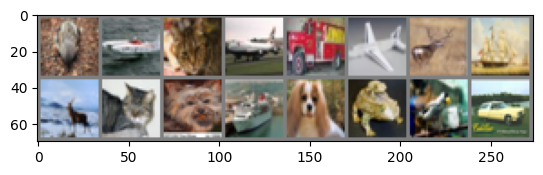

bird  ship  cat   plane truck plane deer  ship  deer  cat   dog   ship  dog   frog  bird  car  


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [18]:
import torch.nn as nn
import torch.nn.functional as F
    
# set the same seed for fair comparisons
torch.manual_seed(seed_n)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [19]:
import torch.optim as optim
from fairret.statistic import Accuracy
from fairret.loss import NormLoss
from humancompatible.train.fairness.utils import BalancedBatchSampler

# define the loss function and the 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# define the criterion
statistic = Accuracy()
fair_criterion = NormLoss(statistic=statistic, p=1)

In [20]:
def test_network(network):
    
    # prepare count for correct answers
    correct = 0
    total = 0

    # prepare fairness counts

    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # prepare accuracy per group
    soft_acc_per_group = torch.zeros(10)

    loss_log = []
    c_log = []

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():

        for data in testloader:
            
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = network(images)

            # compute the loss
            loss = criterion(outputs, labels)   

            # save the logs
            loss_log.append(loss.detach().cpu().numpy())
            c_log.append([])

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            probs = torch.softmax(outputs, dim=1)
            
            # compute the accuracy overall
            correct += (predicted == labels).sum().item()

            # compute the fairness - soft accuracy per group
            accuracy_per_group = probs.gather(1, labels.unsqueeze(1)).squeeze()

            # compute per class accuracy for this batch
            batch_item_iter = 0
            for label, prediction in zip(labels, predicted):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                
                # add the soft prediction
                soft_acc_per_group[label] += accuracy_per_group[batch_item_iter]
                batch_item_iter += 1

                total_pred[classes[label]] += 1

            # save the value of the constraint
            overall_accuracy = soft_acc_per_group.mean()
            constr = torch.norm(1 - soft_acc_per_group / overall_accuracy, p=1)

            c_log[-1].append(constr.detach().cpu().numpy())

    # compute the accuracy per class
    for classname, correct_count in correct_pred.items():
        accuracy = float(correct_count) / total_pred[classname]
        soft_acc_per_group[ class_ind[classname] ] /= total_pred[classname]
        correct_pred[classname] = accuracy

    # compute the constraint 
    overall_accuracy = soft_acc_per_group.mean()
    constr = torch.norm(1 - soft_acc_per_group / overall_accuracy, p=1)

    # returns loss, constraints, total hard accuracy, hard accuracy per group, soft accuracy per group
    return loss_log, c_log, correct / total , correct_pred, constr, soft_acc_per_group

In [21]:
def print_groups(tensor_per_group_acc):
    """Accuracy with class labels
    """

    correct_pred = {classname: 0 for classname in classes}
    for classname, _ in correct_pred.items():
            correct_pred[ classname ] = tensor_per_group_acc[class_ind[classname]].detach().cpu().item()
    
    return correct_pred

In [22]:
import copy

# alloc the logging arrays for the batch
loss_log = []
c_log = []

# alloc arrays for plotting
S_loss_log_plotting = []  # mean
S_c_log_plotting = []  # mean
S_loss_std_log_plotting = []  # std
S_c_std_log_plotting = []  # std

test_S_loss_log_plotting = []  # mean
test_S_c_log_plotting = []  # mean
test_S_loss_std_log_plotting = []  # std
test_S_c_std_log_plotting = []  # std

# save the accuracy per class
accuracy_plotting = []
accuracy_per_class_plotting = []
accuracy_plotting_t = []
accuracy_per_class_plotting_t = []

for epoch in range(n_epochs):  # loop over the dataset multiple times

    # predictions + predictions per group stats
    total_pred_epoch = {classname: 0 for classname in classes}
    correct_pred_epoch = {classname: 0 for classname in classes}
    soft_acc_per_group_epoch = torch.zeros(10)
    total_epoch = 0
    correct_epoch = 0

    for i, data in enumerate(trainloader, 0):

        ############################ FORWARD ###########

        # prepare accuracy per group
        soft_acc_per_group_running = torch.zeros(10)
        total_running = torch.zeros(10)

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1) # compute the classes predictions
        probs = torch.softmax(outputs, dim=1) # compute the probablities


        ############################ CONSTRAINTS + STATISTICS ###########

        # compute the accuracy overall
        total_epoch += labels.size(0)
        correct_epoch += (predicted == labels).sum().item()

        # compute the fairness - soft accuracy per group
        accuracy_per_group = probs.gather(1, labels.unsqueeze(1)).squeeze()

        # compute the constraints - accuracy among all groups
        for idx, zipped in enumerate(zip(labels, predicted)):
            label, prediction = zipped
            if label == prediction:
                correct_pred_epoch[classes[label]] += 1
                
            # save the number of samples per that group in the batch
            total_pred_epoch[classes[label]] += 1
            total_running[label] += 1

            # add the soft prediction
            soft_acc_per_group_running[label] += accuracy_per_group[idx]

        # add the running accuracy to the whole accuracy
        soft_acc_per_group_epoch += soft_acc_per_group_running

        # normalize the accuracy by the number of samples
        for idx, total_count in enumerate(total_running.numpy()):
            if total_count != 0:
                soft_acc_per_group_running[ idx ] /= total_count # change this to total in this epoch

        # save the value of the constraint
        overall_accuracy_batch = soft_acc_per_group_running.mean()
        constr = torch.norm(1 - soft_acc_per_group_running / overall_accuracy_batch, p=1)

        c_log.append([])
        c_log[-1].append(constr.detach().cpu().numpy())

        ############################ BACKPROPAGATION ###########

        # compute the loss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # save the logs
        loss_log.append(loss.detach().cpu().numpy())


        ############################ PRINT ###########

        # print the statistics
        if i % 1000 == 100:    # print every 2000 mini-batches

            S_loss_log_plotting.append(np.mean(loss_log))
            S_c_log_plotting.append(np.mean(c_log, axis=0))
            S_loss_std_log_plotting.append(np.std(loss_log, axis=0))
            S_c_std_log_plotting.append(np.std(c_log, axis=0))

            # test the network after each epoch
            losses_test, c_test, overall_accuracy_t, acc_pergroup_t, constr_t, soft_acc_per_group_t = test_network(net)

            # compute the accuracy per class    
            for classname, correct_count in correct_pred_epoch.items():
                accuracy = float(correct_count) / total_pred_epoch[classname]
                soft_acc_per_group_epoch[ class_ind[classname] ] /= total_pred_epoch[classname]
                correct_pred_epoch[classname] = accuracy

            test_S_loss_log_plotting.append(np.mean(losses_test))
            test_S_c_log_plotting.append(np.mean(c_test, axis=0))
            test_S_loss_std_log_plotting.append(np.std(losses_test, axis=0))
            test_S_c_std_log_plotting.append(np.std(c_test, axis=0))

            accuracy_plotting += [correct_epoch/total_epoch]
            accuracy_per_class_plotting += [ copy.deepcopy(correct_pred_epoch) ]
            accuracy_plotting_t += [overall_accuracy_t]
            accuracy_per_class_plotting_t += [ copy.deepcopy(acc_pergroup_t) ]

            print(
                f"Step: {epoch}, {i + 1:5d}, "
                f"loss ({np.mean(loss_log):.4f}/{np.mean(losses_test):.4f}):"
                f"constraints (train/test): ({np.max(np.abs(np.mean(c_log, axis=0))):.4f}/{np.max(np.abs(np.mean(c_test, axis=0))):.4f}), "
                # f"Accuracy (hrad/soft): {correct_epoch/total_epoch}/{soft_acc_per_group_epoch.mean().detach().cpu().item()}"
                f"Accuracy (train/test): {correct_epoch/total_epoch}/{soft_acc_per_group_epoch.mean()}\n"
                f"Accuracy Per group (train): {correct_pred_epoch}\n"
                f"Soft Accuracy Per group (train): {print_groups(soft_acc_per_group_epoch)}\n"
                ""
            )

            # restart the stats        
            total_pred_epoch = {classname: 0 for classname in classes}
            correct_pred_epoch = {classname: 0 for classname in classes}
            soft_acc_per_group_epoch = torch.zeros(10)
            total_epoch = 0
            correct_epoch = 0

    
print('Finished Training')

Step: 0,   101, loss (2.2214/2.0709):constraints (train/test): (4.4547/2.4303), Accuracy (train/test): 0.16212871287128713/0.11524824053049088
Accuracy Per group (train): {'plane': 0.1258741258741259, 'car': 0.24390243902439024, 'bird': 0.0, 'cat': 0.04477611940298507, 'deer': 0.011428571428571429, 'dog': 0.2611464968152866, 'frog': 0.1320754716981132, 'horse': 0.07407407407407407, 'ship': 0.3333333333333333, 'truck': 0.3522727272727273}
Soft Accuracy Per group (train): {'plane': 0.13360466063022614, 'car': 0.12071891129016876, 'bird': 0.09573163837194443, 'cat': 0.09563032537698746, 'deer': 0.09705008566379547, 'dog': 0.11222619563341141, 'frog': 0.1026182621717453, 'horse': 0.10097341239452362, 'ship': 0.15791276097297668, 'truck': 0.13601623475551605}

Step: 0,  1101, loss (1.7477/1.5299):constraints (train/test): (6.1111/2.8813), Accuracy (train/test): 0.370875/0.2473481446504593
Accuracy Per group (train): {'plane': 0.4222636815920398, 'car': 0.5102432778489117, 'bird': 0.12157107

In [23]:
import numpy as np

# resave the path
np.savez(
    log_path,
    losses=[],
    constraints=[],
    losses_std=[],
    constraints_std=[],
    losses_t=[],
    constraints_t=[],
    losses_std_t=[],
    constraints_std_t=[],
    accuracy = [],
    accuracy_per_group = [],
    accuracy_t = [],
    accuracy_per_group_t = []
)

In [24]:
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"])
constraints_std = list(np.load(log_path)["constraints_std"])
losses_t = list(np.load(log_path)["losses_t"])
constraints_t = list(np.load(log_path)["constraints_t"])
losses_std_t = list(np.load(log_path)["losses_std_t"])
constraints_std_t = list(np.load(log_path)["constraints_std_t"])
accuracy = list(np.load(log_path)["accuracy"])
accuracy_per_group = list(np.load(log_path)["accuracy_per_group"])
accuracy_t = list(np.load(log_path)["accuracy_t"])
accuracy_per_group_t = list(np.load(log_path)["accuracy_per_group_t"])

# append
losses += [np.array(S_loss_log_plotting)]
constraints += [np.array(S_c_log_plotting).T]
losses_std += [np.array(S_loss_std_log_plotting)]
constraints_std += [np.array(S_c_std_log_plotting).T]

losses_t += [np.array(test_S_loss_log_plotting)]
constraints_t += [np.array(test_S_c_log_plotting).T]
losses_std_t += [np.array(test_S_loss_std_log_plotting)]
constraints_std_t += [np.array(test_S_c_std_log_plotting).T]

accuracy += [accuracy_plotting]
accuracy_per_group += [accuracy_per_class_plotting]
accuracy_t += [accuracy_plotting_t]
accuracy_per_group_t += [accuracy_per_class_plotting_t]

# save the computed data
np.savez(
    log_path,
    losses=losses,
    constraints=constraints,
    losses_std=losses_std,
    constraints_std=constraints_std,
    losses_t=losses_t,
    constraints_t=constraints_t,
    losses_std_t=losses_std_t,
    constraints_std_t=constraints_std_t,
    accuracy = accuracy,
    accuracy_per_group = accuracy_per_group,
    accuracy_t = accuracy_t,
    accuracy_per_group_t = accuracy_per_group_t
)

In [25]:
import numpy as np
import matplotlib.pyplot as plt


def plot_losses_and_constraints_stochastic(
    train_losses_list,
    train_losses_std_list,
    train_constraints_list,
    train_constraints_std_list,
    constraint_thresholds,
    test_losses_list=None,
    test_losses_std_list=None,
    test_constraints_list=None,
    test_constraints_std_list=None,
    titles=None,
    eval_points=1,
    std_multiplier=2,
    log_constraints=False,
    mode="train",  # "train" or "train_test"
    plot_time_instead_epochs=False
):
    """
    mode:
        "train"       -> only training plots
        "train_test"  -> training + test side by side
    """

    # --- Color palette (Tableau 10) ---
    colors = [
        "#4E79A7",
        "#F28E2B",
        "#E15759",
        "#76B7B2",
        "#59A14F",
        "#EDC948",
        "#B07AA1",
        "#FF9DA7",
        "#9C755F",
        "#BAB0AB",
    ]

    marker_styles = ["o", "s", "D", "^", "v", "<", ">", "P", "X", "*"]

    num_algos = len(train_losses_list)
    if titles is None:
        titles = [f"Algorithm {i + 1}" for i in range(num_algos)]

    constraint_thresholds = np.atleast_1d(constraint_thresholds)

    # --- Layout ---
    ncols = 1 if mode == "train" else 2
    fig, axes = plt.subplots(2, ncols, figsize=(9 * ncols, 10), sharex="col")

    if ncols == 1:
        axes = np.array([[axes[0]], [axes[1]]])

    # ======================================================
    # Helper plotting functions
    # ======================================================

    def plot_loss(ax, losses_list, losses_std_list, title_suffix):
        for j, (loss, loss_std) in enumerate(zip(losses_list, losses_std_list)):
            x = np.arange(len(loss))
            color = colors[j % len(colors)]
            upper = loss + std_multiplier * loss_std
            lower = loss - std_multiplier * loss_std

            ax.plot(x, loss, lw=2.2, color=color, label=titles[j])
            ax.fill_between(x, lower, upper, color=color, alpha=0.15)

            if eval_points is not None:
                idx = (
                    np.arange(0, len(loss), eval_points)
                    if isinstance(eval_points, int)
                    else np.array(eval_points)
                )
                idx = idx[idx < len(loss)]
                ax.plot(
                    x[idx],
                    loss[idx],
                    marker_styles[j % len(marker_styles)],
                    color=color,
                    markersize=6,
                    alpha=0.8,
                )

        ax.set_title(f"Loss ({title_suffix})")
        ax.set_ylabel("Mean Loss")
        ax.grid(True, linestyle="--", alpha=0.35)
        ax.legend(fontsize=9)

    def plot_constraints(ax, constraints_list, constraints_std_list, title_suffix):
        for j, (constraints, constraints_std) in enumerate(
            zip(constraints_list, constraints_std_list)
        ):
            color = colors[j % len(colors)]
            constraints = np.asarray(constraints)
            constraints_std = np.asarray(constraints_std)

            x = np.arange(constraints.shape[1])

            c_min = np.min(constraints - std_multiplier * constraints_std, axis=0)
            c_max = np.max(constraints + std_multiplier * constraints_std, axis=0)

            ax.fill_between(x, c_min, c_max, color=color, alpha=0.1)

            for c_mean in constraints:

                ax.plot(x, c_mean, lw=1.8, color=color, alpha=0.3)

                if eval_points is not None:
                    idx = (
                        np.arange(0, len(c_mean), eval_points)
                        if isinstance(eval_points, int)
                        else np.array(eval_points)
                    )
                    idx = idx[idx < len(c_mean)]
                    ax.plot(
                        x[idx],
                        c_mean[idx],
                        marker_styles[j % len(marker_styles)],
                        color=color,
                        markersize=5,
                        alpha=0.3,
                    )

        for th in constraint_thresholds:
            y = np.log(th) if log_constraints else th
            ax.axhline(y, color="red", linestyle="--", lw=1.4, label="Threshold")

        ax.set_title(f"Constraint ({title_suffix})")
        ax.set_ylabel("Log Constraint" if log_constraints else "Constraint")

        if plot_time_instead_epochs:
            ax.set_xlabel("Time (m)")
        else: 
            ax.set_xlabel("Epoch")
        ax.grid(True, linestyle="--", alpha=0.35)
        ax.legend(fontsize=9)

    # ======================================================
    # TRAIN PLOTS
    # ======================================================

    plot_loss(axes[0, 0], train_losses_list, train_losses_std_list, "Train")
    plot_constraints(
        axes[1, 0],
        train_constraints_list,
        train_constraints_std_list,
        "Train",
    )

    # ======================================================
    # TEST PLOTS
    # ======================================================

    if mode == "train_test":
        plot_loss(axes[0, 1], test_losses_list, test_losses_std_list, "Test")
        plot_constraints(
            axes[1, 1],
            test_constraints_list,
            test_constraints_std_list,
            "Test",
        )

    plt.tight_layout()
    plt.show()

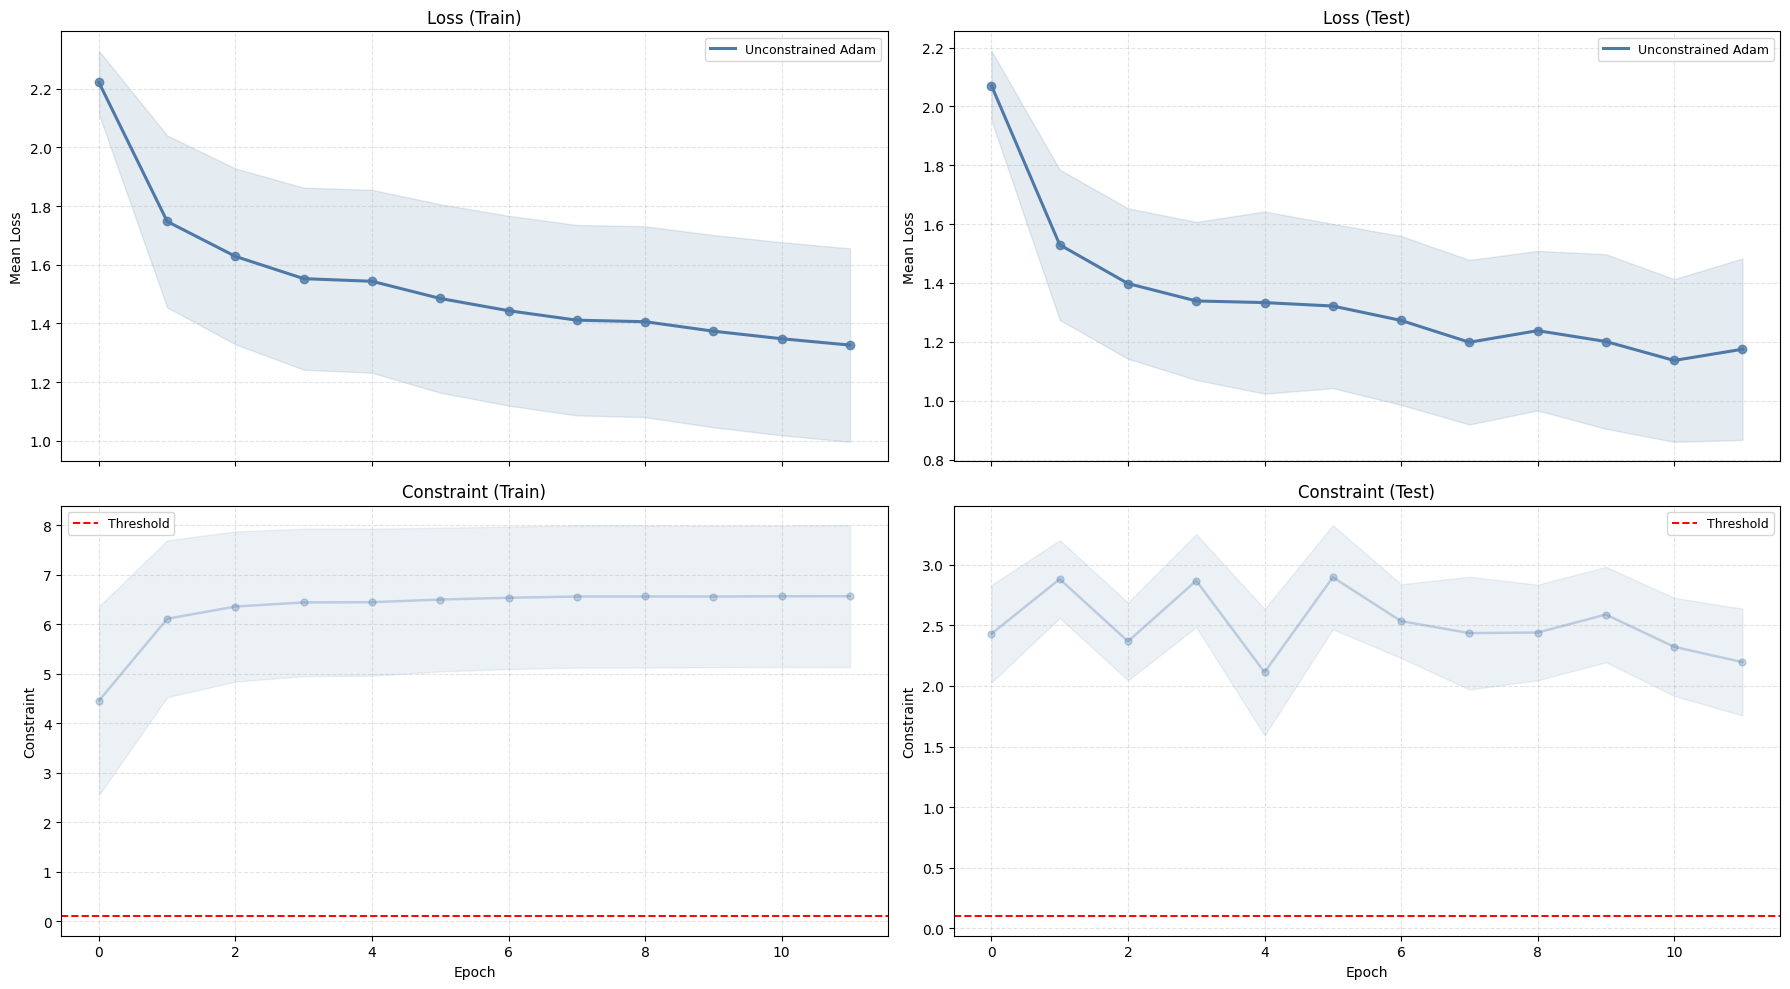

In [26]:
# plot the results

losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"])
constraints_std = list(np.load(log_path)["constraints_std"])
losses_t = list(np.load(log_path)["losses_t"])
constraints_t = list(np.load(log_path)["constraints_t"])
losses_std_t = list(np.load(log_path)["losses_std_t"])
constraints_std_t = list(np.load(log_path)["constraints_std_t"])
accuracy = list(np.load(log_path)["accuracy"])
accuracy_per_group = list(np.load(log_path,allow_pickle=True)["accuracy_per_group"])
accuracy_t = list(np.load(log_path)["accuracy_t"])
accuracy_per_group_t = list(np.load(log_path,allow_pickle=True)["accuracy_per_group_t"])

plot_losses_and_constraints_stochastic(
    losses,
    losses_std,
    constraints,
    constraints_std,
    [fair_crit_bound],
    test_losses_list=losses_t,
    test_losses_std_list=losses_std_t,
    test_constraints_list=constraints_t,
    test_constraints_std_list=constraints_std_t,
    titles=[
        "Unconstrained Adam",
        "SSW",
        "SSLALM-Adam",
        "PBM"
    ],
    log_constraints=False,
    std_multiplier=1,
    mode='train_test', # change this to 'train', to ignore the test
    plot_time_instead_epochs=False
)

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def plot_accuracy_per_epoch(algorithms_data, titles=None, eval_points=1):
    """
    Plots accuracy per epoch for each algorithm and each label found in the dictionaries.

    Parameters:
    - algorithms_data: List of length N, each element is a list of K dictionaries (one per epoch).
    - titles: List of titles for each algorithm (default: "Algorithm 1", ...).
    - eval_points: Evaluate points for markers (default: 1).
    - std_multiplier: Multiplier for standard deviation (default: 2).
    """
    # --- Color palette (Tableau 10) ---
    colors = [
        "#4E79A7",
        "#F28E2B",
        "#E15759",
        "#76B7B2",
        "#59A14F",
        "#EDC948",
        "#B07AA1",
        "#FF9DA7",
        "#9C755F",
        "#BAB0AB",
    ]

    marker_styles = ["o", "s", "D", "^", "v", "<", ">", "P", "X", "*"]

    num_algos = len(algorithms_data)
    if titles is None:
        titles = [f"Algorithm {i + 1}" for i in range(num_algos)]

    # --- Layout ---
    fig, axes = plt.subplots(num_algos, 1, figsize=(9, 4*num_algos), sharex=True)

    if num_algos == 1:
        axes = [axes]  # Ensure axes is iterable

    for i, (ax, algorithm_epochs) in enumerate(zip(axes, algorithms_data)):
        K = len(algorithm_epochs)
        labels = list(algorithm_epochs[0].keys())

        for j, label in enumerate(labels):
            color = colors[j % len(colors)]
            y = np.array([epoch[label] for epoch in algorithm_epochs])
            x = np.arange(1, K+1)
            ax.plot(x, y, lw=2.2, color=color, label=label)

            if eval_points is not None:
                idx = (
                    np.arange(0, len(y), eval_points)
                    if isinstance(eval_points, int)
                    else np.array(eval_points)
                )
                idx = idx[idx < len(y)]
                ax.plot(
                    x[idx],
                    y[idx],
                    marker_styles[j % len(marker_styles)],
                    color=color,
                    markersize=6,
                    alpha=0.8,
                )

        ax.set_title(titles[i])
        ax.set_xlabel("Step")
        ax.set_ylabel("Accuracy")
        ax.grid(True, linestyle="--", alpha=0.35)
        ax.legend(fontsize=9)

    plt.tight_layout()
    plt.show()


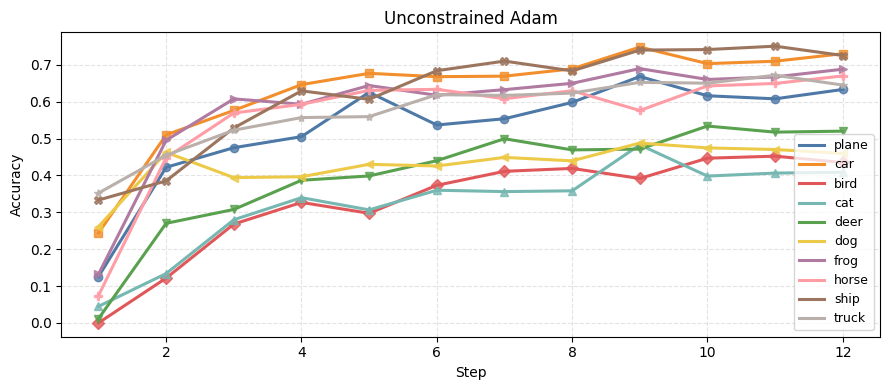

In [39]:
plot_accuracy_per_epoch(accuracy_per_group, titles=["Unconstrained Adam"])

In [18]:
torch.save(net.state_dict(), PATH_CHECKPOINT)

In [19]:
net = Net().to(device)
net.load_state_dict(torch.load(PATH_CHECKPOINT, weights_only=True))


<All keys matched successfully>